# Introduction to Nebula Pipelines

This notebook demonstrates the basics of building **flat (linear) pipelines** with Nebula.

A flat pipeline is a sequence of transformers that are executed in order, one after another.

You will learn how to:
1. Create a pipeline from a list of transformers
2. Nest pipelines within pipelines
3. Visualize a pipeline with `show()` and `plot()`
4. Run a pipeline with `run()`

In [1]:
import polars as pl

from nebula import TransformerPipeline
from nebula.transformers import (
    AssertNotEmpty,
    DropColumns,
    RenameColumns,
    SelectColumns,
)

## 1. Creating a Simple Pipeline

A `TransformerPipeline` takes a list of transformers and functions and executes them sequentially.

Each transformer must be **instantiated** (i.e., you call it with its parameters).

In [2]:
def simple_function(_df):
    print(f"Hello I'm 'simple_function' -> this is a: {type(_df)}")
    return _df

def function_with_args_and_kwargs(_df, *args, coef, factor):
    print(f"Hello I'm 'function_with_args_and_kwargs' -> this is a: {type(_df)}")
    return _df

pipe = TransformerPipeline(
    [
        DropColumns(columns=["temp_col"], allow_excess_columns=True),
        SelectColumns(columns=["id", "name", "value"]),
        # To add a description, insert the transformer in a 2-element tuple, where the 2nd element is the description
        (AssertNotEmpty(), "Ensure the DF is not empty"),
        # pass a simple function
        simple_function,
        # to pass args, kwargs and description use a 2/3/4-element tuple
        # 1st element: the function
        # 2nd element: <list> / <tuple> of *args
        # 3rd element: <dict> of **kwargs
        # 4th element: <str> description
        (function_with_args_and_kwargs, [1, 2, 3, 4, 5], {"coef": 10, "factor": [20, {"a": 30}]}, "random function"),

        {"store": "this_key"}

        # nested list, it will be flatten/merged with the outermost
        # [(AssertNotEmpty(), "Ensure the DF is not empty"), AssertNotEmpty(), {"store", "this key"}]

        # flatten like
        # (AssertNotEmpty(), "Ensure the DF is not empty"),
        # AssertNotEmpty()
        # {"store", "this key"}
    ],
    name="Simple Pipeline",
)

## 2. Visualizing the Pipeline

### 2.1 Text visualization with `show()`

Use `show()` to print a text representation of the pipeline structure.

In [3]:
pipe.show()

*** Simple Pipeline *** (5 transformations)
 - DropColumns
 - SelectColumns
 - AssertNotEmpty
     Description: Ensure the DF is not empty
 - simple_function
 - function_with_args_and_kwargs
     Description: random function
   --> Store df with key "this_key"


To include transformer initialization parameters, set `add_params=True`:

In [4]:
pipe.show(add_params=True)

*** Simple Pipeline *** (5 transformations)
 - DropColumns -> PARAMS: allow_excess_columns=True, columns=['temp_col']
 - SelectColumns -> PARAMS: columns=['id', 'name', 'value']
 - AssertNotEmpty
     Description: Ensure the DF is not empty
 - simple_function
 - function_with_args_and_kwargs -> ARGS=[1, 2, 3, 4, 5], KWARGS={'coef': 10, 'factor': [20, {'a': 30}]}
     Description: random function
   --> Store df with key "this_key"


### 2.2 Graphical visualization with `plot()`

If [Graphviz](https://graphviz.org/download/) and `pyyaml` is installed, you can render the pipeline as a directed acyclic graph (DAG).

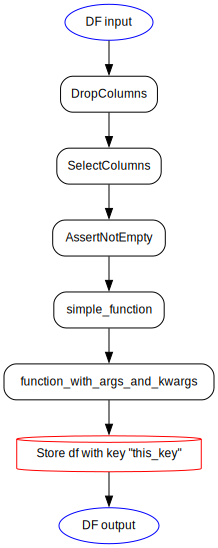

In [5]:
pipe.plot()

To include transformer initialization parameters, set `add_params=True`, to include their description, set `add_description=True`:

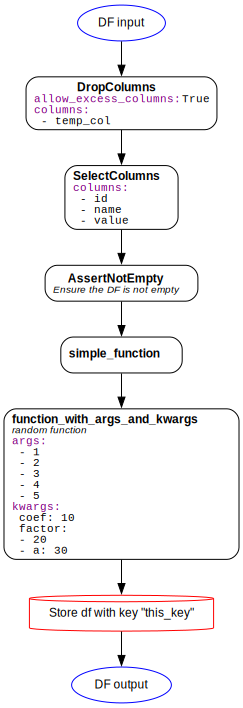

In [6]:
pipe.plot(add_params=True, add_description=True)

## 3. Running the Pipeline

Use `run()` to execute the pipeline on a dataframe.

Nebula supports multiple backends: **Polars**, **Pandas**, and **PySpark**. The output dataframe will be the same type as the input.

In [7]:
# Create a sample dataframe
df_input = pl.DataFrame({
    "id": [1, 2, 3],
    "name": ["Alice", "Bob", "Charlie"],
    "value": [100, 200, 300],
    "extra": ["x", "y", "z"],  # This column will be dropped by SelectColumns
})

print("Input DataFrame:")
df_input

Input DataFrame:


id,name,value,extra
i64,str,i64,str
1,"""Alice""",100,"""x"""
2,"""Bob""",200,"""y"""
3,"""Charlie""",300,"""z"""


In [8]:
# Run the pipeline
df_output = pipe.run(df_input, show_params=True)
print(df_output)

2025-12-25 23:01:00,554 | [INFO]: Starting pipeline 'Simple Pipeline' 
2025-12-25 23:01:00,554 | [INFO]: Running 'DropColumns' PARAMS: allow_excess_columns=True, columns=['temp_col'] ... 
2025-12-25 23:01:00,567 | [INFO]: Completed 'DropColumns' in 0.0s 
2025-12-25 23:01:00,568 | [INFO]: Running 'SelectColumns' PARAMS: columns=['id', 'name', 'value'] ... 
2025-12-25 23:01:00,569 | [INFO]: Completed 'SelectColumns' in 0.0s 
2025-12-25 23:01:00,570 | [INFO]: Running 'AssertNotEmpty' ... 
2025-12-25 23:01:00,570 | [INFO]: Completed 'AssertNotEmpty' in 0.0s 
2025-12-25 23:01:00,570 | [INFO]: Running 'simple_function' ... 
2025-12-25 23:01:00,570 | [INFO]: Completed 'simple_function' in 0.0s 
2025-12-25 23:01:00,570 | [INFO]: Running 'function_with_args_and_kwargs': ARGS=[1, 2, 3, 4, 5], KWARGS={'coef': 10, 'factor': [20, {'a': 30}]} ... 
2025-12-25 23:01:00,570 | [INFO]: Completed 'function_with_args_and_kwargs' in 0.0s 
2025-12-25 23:01:00,570 | [INFO]:    --> Store df with key "this_key"

Hello I'm 'simple_function' -> this is a: <class 'polars.dataframe.frame.DataFrame'>
Hello I'm 'function_with_args_and_kwargs' -> this is a: <class 'polars.dataframe.frame.DataFrame'>
shape: (3, 3)
┌─────┬─────────┬───────┐
│ id  ┆ name    ┆ value │
│ --- ┆ ---     ┆ ---   │
│ i64 ┆ str     ┆ i64   │
╞═════╪═════════╪═══════╡
│ 1   ┆ Alice   ┆ 100   │
│ 2   ┆ Bob     ┆ 200   │
│ 3   ┆ Charlie ┆ 300   │
└─────┴─────────┴───────┘


## 4. Nesting Pipelines

Pipelines can contain other pipelines, allowing you to organize complex transformations into logical groups.

In [9]:
# Define sub-pipelines for different stages
validation_pipe = TransformerPipeline(
    [
        AssertNotEmpty(),
    ],
    name="Validation",
)

cleaning_pipe = TransformerPipeline(
    [
        DropColumns(glob="temp*"),
        RenameColumns(mapping={"old_name": "new_name"}),
    ],
    name="Cleaning",
)

selection_pipe = TransformerPipeline(
    [
        SelectColumns(columns=["id", "new_name", "score"]),
    ],
    name="Selection",
)

# Combine into a master pipeline
master_pipe = TransformerPipeline(
    [
        validation_pipe,
        cleaning_pipe,
        selection_pipe,
    ],
    name="Master Pipeline",
)

In [10]:
# Visualize the nested structure
master_pipe.show(add_params=True)

*** Master Pipeline *** (4 transformations)
 - AssertNotEmpty
*** Cleaning *** (2 transformations)
 - DropColumns -> PARAMS: glob="temp*"
 - RenameColumns -> PARAMS: mapping={'old_name': 'new_name'}
 - SelectColumns -> PARAMS: columns=['id', 'new_name', 'score']


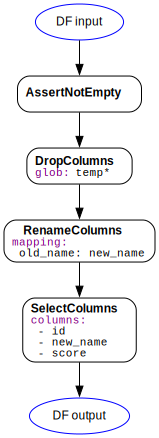

In [11]:
# Plot the nested pipeline
master_pipe.plot(add_params=True)

In [12]:
# Run the nested pipeline
df_nested_input = pl.DataFrame({
    "id": [1, 2, 3],
    "old_name": ["Alice", "Bob", "Charlie"],
    "score": [85, 92, 78],
    "temp": ["drop_me", "drop_me", "drop_me"],
})

print("Input DataFrame:")
print(df_nested_input)
print()

df_nested_output = master_pipe.run(df_nested_input)

print("\nOutput DataFrame:")
print(df_nested_output)

2025-12-25 23:01:00,809 | [INFO]: Starting pipeline 'Master Pipeline' 
2025-12-25 23:01:00,809 | [INFO]: Running 'AssertNotEmpty' ... 
2025-12-25 23:01:00,814 | [INFO]: Completed 'AssertNotEmpty' in 0.0s 
2025-12-25 23:01:00,814 | [INFO]: Running 'DropColumns' ... 
2025-12-25 23:01:00,816 | [INFO]: Completed 'DropColumns' in 0.0s 
2025-12-25 23:01:00,816 | [INFO]: Running 'RenameColumns' ... 
2025-12-25 23:01:00,817 | [INFO]: Completed 'RenameColumns' in 0.0s 
2025-12-25 23:01:00,819 | [INFO]: Running 'SelectColumns' ... 
2025-12-25 23:01:00,820 | [INFO]: Completed 'SelectColumns' in 0.0s 
2025-12-25 23:01:00,820 | [INFO]: Pipeline 'Master Pipeline' completed in 0.0s 


Input DataFrame:
shape: (3, 4)
┌─────┬──────────┬───────┬─────────┐
│ id  ┆ old_name ┆ score ┆ temp    │
│ --- ┆ ---      ┆ ---   ┆ ---     │
│ i64 ┆ str      ┆ i64   ┆ str     │
╞═════╪══════════╪═══════╪═════════╡
│ 1   ┆ Alice    ┆ 85    ┆ drop_me │
│ 2   ┆ Bob      ┆ 92    ┆ drop_me │
│ 3   ┆ Charlie  ┆ 78    ┆ drop_me │
└─────┴──────────┴───────┴─────────┘


Output DataFrame:
shape: (3, 3)
┌─────┬──────────┬───────┐
│ id  ┆ new_name ┆ score │
│ --- ┆ ---      ┆ ---   │
│ i64 ┆ str      ┆ i64   │
╞═════╪══════════╪═══════╡
│ 1   ┆ Alice    ┆ 85    │
│ 2   ┆ Bob      ┆ 92    │
│ 3   ┆ Charlie  ┆ 78    │
└─────┴──────────┴───────┘


## Summary

In this notebook you learned the basics of Nebula flat pipelines:

| Method | Description |
|--------|-------------|
| `TransformerPipeline([...], name="...")` | Create a pipeline from a list of transformers |
| `pipe.show()` | Print a text representation of the pipeline |
| `pipe.plot()` | Render the pipeline as a DAG (requires Graphviz and pyyaml) |
| `pipe.run(df)` | Execute the pipeline on a dataframe |

**Next steps:**
- **split pipelines** for parallel processing branches
- **storage** for caching intermediate results, debugging, and passing dataframes to non-following steps
- **YAML/JSON configuration** for declarative pipeline definitions
- **custom transformers and custom functions** to define your own transformations
- **branch and apply_to_rows** capabilities for forking and merging dataframes
- **skip options** to turn off transformations, branches or entire sub-pipelines
- **LazyTransformer** to initialize transformers at runtime instead of at compilation time
- **interleaved operations** for debugging purposes
- **pipeline compounding** to combine sub-pipelines into a complex one
- **YAML/JSON for-loops** for declarative iteration in text configuration
- **real case usage** showing an actual complex pipeline in action
- **Spark transformers** for Spark backend